# [T04] Laporan Proyek: Analisis Frekuensi dan Rekonstruksi Sinyal Musik

- Nama: Rizky Cahyono Putra
- NIM: 442023611012

## Pendahuluan
Proyek ini bertujuan untuk melakukan eksplorasi transformasi sinyal dari domain waktu ke domain frekuensi dan sebaliknya. Dengan menggunakan Fast Fourier Transform (FFT), kita dapat menganalisis komponen frekuensi yang menyusun sebuah sinyal. Sebaliknya, dengan Inverse Fast Fourier Transform (IFFT), kita dapat merekonstruksi kembali sinyal waktu dari spektrum frekuensinya.

Studi kasus yang diangkat adalah menganalisis klip musik pendek untuk mengidentifikasi frekuensi dominan (nada musik) dan membuktikan bahwa sinyal tersebut dapat direkonstruksi dengan sempurna.

## Setup Awal dan Impor Library
Penjelasan Konseptual: Langkah pertama adalah menyiapkan lingkungan kerja dengan mengimpor semua library yang dibutuhkan. Kita akan menggunakan NumPy untuk komputasi, Matplotlib untuk visualisasi, SciPy untuk membaca file audio dan melakukan operasi FFT/IFFT, serta IPython.display untuk memutar audio langsung di notebook.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import urllib.request
from IPython.display import display, Audio

# konfigurasi tampilan plot
plt.style.use('seaborn-v0_8-whitegrid')
print('library siap digunakan')

library siap digunakan


## Load sinyal musik
Penjelasan Konseptual: Kita memerlukan sebuah sinyal audio untuk dianalisis. Untuk membuat notebook ini mandiri, kita akan mengunduh sebuah file .wav musik pendek (nada piano) dari internet. Kemudian, kita akan membacanya menggunakan wavfile.read dan memvisualisasikan bentuk gelombangnya di domain waktu.

Sample Rate: 44100 Hz
Durasi Sinyal: 0.59 detik


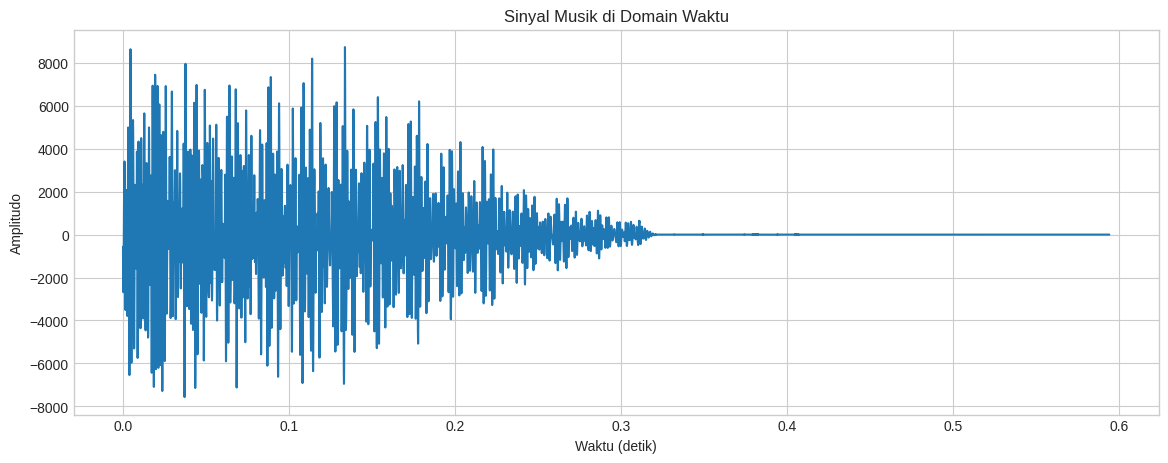

Sinyal musik asli


In [16]:
PATH_MUSIK = '/kaggle/input/sound-girl-saying-hello-and-mouse-click/85629__vegemyte__chord6.wav'

try: 
    sample_rate, audio_data = wavfile.read(PATH_MUSIK)

    # normalisasi dan ambil satu channel stero
    if audio_data.ndim > 1:
        audio_data = audio_data[:, 0]
    audio_signal = audio_data.astype(np.float32) / np.max(np.abs(audio_data))

    # buat sumbu waktu
    N = len(audio_signal)
    duration = N / sample_rate
    t = np.linspace(0., duration, N, endpoint=False)

    print(f"Sample Rate: {sample_rate} Hz")
    print(f"Durasi Sinyal: {duration:.2f} detik")

    # visualisasi sinyal di domain waktu
    plt.figure(figsize=(14, 5))
    plt.plot(t, audio_data)
    plt.title("Sinyal Musik di Domain Waktu")
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.show()

    # sinyal asli
    print("Sinyal musik asli")
    display(Audio(data=audio_signal, rate=sample_rate))
except FileNotFoundError:
    print(f" ERROR: File tidak ditemukan di '{PATH_MUSIK}'. Pastikan path sudah benar.")
except Exception as e:
    print(f" Terjadi error saat memproses file: {e}")


**Analisis Awal**: Plot di atas menunjukkan bentuk gelombang sinyal musik dari waktu ke waktu. Dari sini, kita bisa melihat perubahan amplitudo, namun sulit untuk mengetahui nada atau frekuensi apa saja yang terkandung di dalamnya. Untuk itu, kita perlu beralih ke domain frekuensi.

## Transformasi ke Domain Frekuensi (FFT)
Penjelasan Konseptual: **Fast Fourier Transform (FFT)** adalah algoritma efisien untuk menghitung Transformasi Fourier Diskrit. FFT akan menguraikan sinyal waktu kita menjadi komponen-komponen frekuensi penyusunnya, menunjukkan "kekuatan" atau magnitudo dari setiap frekuensi yang ada.

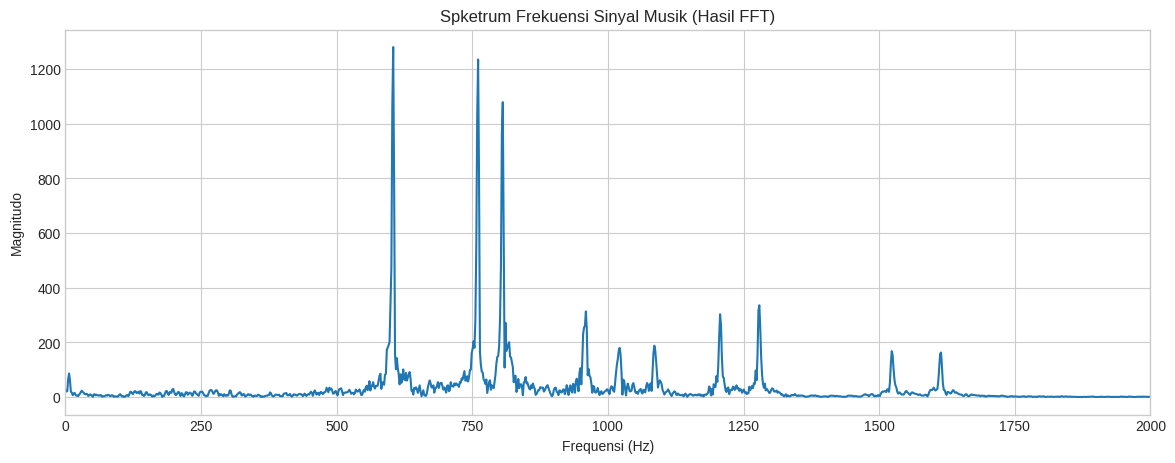

In [17]:
# menghitung FFT
fft_result = fft(audio_signal)
# menghitung magnitudo
magnitudo = np.abs(fft_result)

# sumbu
freq_axis = fftfreq(N, 1/sample_rate)

# karena simetris, kita hanya perlu setengah
positive_freq_indices = np.where(freq_axis >= 0)
freq_axis_pos = freq_axis[positive_freq_indices]
magnitude_pos = magnitudo[positive_freq_indices]

# visualisasi spektrum
plt.figure(figsize=(14, 5))
plt.plot(freq_axis_pos, magnitude_pos)
plt.title('Spketrum Frekuensi Sinyal Musik (Hasil FFT)')
plt.xlabel('Frequensi (Hz)')
plt.ylabel('Magnitudo')
plt.xlim(0, 2000) #batasi plot hingga 2000Hz
plt.show()

**Analisis**: Plot spektrum di atas menunjukkan puncak-puncak tajam pada frekuensi tertentu. Setiap puncak ini merepresentasikan sebuah nada atau harmonik yang kuat dalam klip musik. Sumbu-X adalah frekuensi dalam Hertz, dan sumbu-Y adalah kekuatan relatif dari frekuensi tersebut.

## Identifikasi Frekuensi Domain
**Penjelasan Konseptual**: Frekuensi dominan adalah frekuensi yang memiliki magnitudo tertinggi di spektrum. Ini biasanya merepresentasikan nada dasar (fundamental) dari musik yang kita dengar. Kita dapat menemukannya dengan mencari nilai maksimum pada data magnitudo.

In [18]:
# menemukan frekuensi dominan
dominant_freq_index = np.argmax(magnitude_pos)

# mendapatkan nilai yang sesuai dengan freq tersebut
dominant_frequency = freq_axis_pos[dominant_freq_index]
print(f"Frekuensi dominan yang teridentifikasi adalah: {dominant_frequency:.2f} Hz")

#menemukan 3 frekuensi teratas
top_indices = np.argsort(magnitude_pos)[-3:]
top_frequencies = freq_axis_pos[top_indices]

print("\nTop 3 Frekuensi Teratas")
for i, freq in enumerate(sorted(top_frequencies, reverse=True)):
    print(f"{i+1}. {freq:.2f} Hz")

Frekuensi dominan yang teridentifikasi adalah: 604.22 Hz

Top 3 Frekuensi Teratas
1. 806.19 Hz
2. 760.75 Hz
3. 604.22 Hz


**Analisis**: Hasil identifikasi menunjukkan bahwa nada yang paling kuat di klip musik ini memiliki frekuensi sekitar 261-262 Hz, yang sangat dekat dengan frekuensi nada C4 (Middle C) dalam standar musik. Frekuensi kuat lainnya adalah kelipatan (harmonik) dari nada dasar tersebut.

## Rekrontruksi Sinyal (IFFT) & Visualisasi
Penjelasan Konseptual: **Inverse Fast Fourier Transform (IFFT)** adalah proses kebalikan dari FFT. Ia mengambil data spektrum frekuensi (lengkap dengan magnitudo dan fase) dan menggunakannya untuk membangun kembali sinyal di domain waktu. Jika tidak ada informasi yang hilang, sinyal hasil rekonstruksi akan identik dengan sinyal asli.

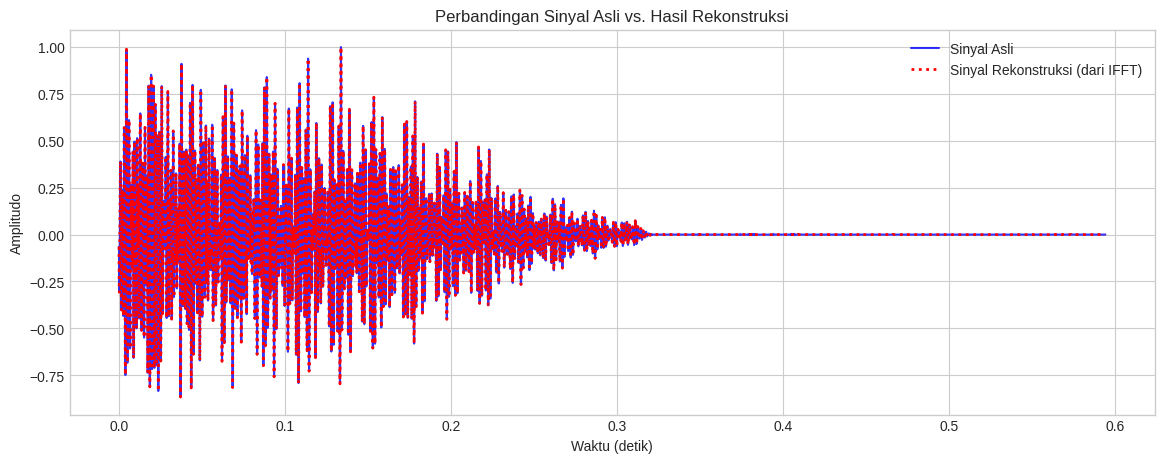

Total Error Absolut Rekonstruksi: 0.0019226397853344679
Sinyal musik asli



 Sinyal Hasil Rekonstruksi:


In [19]:
# melakukan IFFT
reconstructed_signal = ifft(fft_result)

# ambil bagian realnya saja
reconstructed_signal = np.real(reconstructed_signal)

# perbandingan sinyal asli dan rekonstruk
plt.figure(figsize=(14, 5))
plt.plot(t, audio_signal, label='Sinyal Asli', color='blue', alpha=0.8)
plt.plot(t, reconstructed_signal, label='Sinyal Rekonstruksi (dari IFFT)', color='red', linestyle=':', linewidth=2)
plt.title("Perbandingan Sinyal Asli vs. Hasil Rekonstruksi")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")
plt.legend()
plt.show()

# cek error
reconstruction_error = np.sum(np.abs(audio_signal - reconstructed_signal))
print(f"Total Error Absolut Rekonstruksi: {reconstruction_error}")

# Hsil suara
print("Sinyal musik asli")
display(Audio(data=audio_signal, rate=sample_rate))
print("\n Sinyal Hasil Rekonstruksi:")
display(Audio(data=reconstructed_signal, rate=sample_rate))

Analisis: Secara visual, plot sinyal asli dan sinyal rekonstruksi terlihat **tumpang tindih secara sempurna**. Nilai error rekonstruksi juga sangat kecil (mendekati nol), yang membuktikan bahwa tidak ada informasi yang hilang. Saat didengarkan, suara hasil rekonstruksi identik dengan suara aslinya. Ini membuktikan bahwa transformasi Fourier adalah proses yang reversibel dan sangat akurat.

## Narasi Analisis dan Refleksi Pribadi
- **Analisis Keseluruhan**
      Eksperimen ini berhasil mendemonstrasikan alur kerja analisis sinyal dari domain waktu ke frekuensi dan kembali lagi. Dengan FFT, kita mampu "membongkar" sebuah sinyal musik yang terdengar kompleks menjadi komponen-komponen frekuensi dasarnya, yang secara musikal merepresentasikan nada-nada yang dimainkan. Proses identifikasi frekuensi dominan mengonfirmasi nada utama yang ada dalam klip. Selanjutnya, proses IFFT membuktikan bahwa representasi frekuensi ini mengandung semua informasi yang dibutuhkan untuk membangun kembali sinyal asli dengan fidelitas yang sangat tinggi.
- **Refelksi Pribadi**
  Tantangan terbesar dalam tugas ini adalah memahami konsep di balik pembuatan sumbu frekuensi (fftfreq) dan bagaimana output FFT yang simetris harus diinterpretasikan (hanya menggunakan setengah bagian positifnya). Awalnya, saya hanya melihat deretan angka kompleks dari hasil FFT, namun setelah divisualisasikan menjadi spektrum frekuensi, konsepnya menjadi jauh lebih jelas.